<h1 style="border: 1.5px solid #ccc; 
           padding: 8px 12px; 
           color:#56BFCB;"
    >
    <center> <br/>
        Projeto I <br/>
        <span style="font-size:18px;"> Guilherme Esdras </span>
    </center>
</h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import optimize as opt, stats

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')

import sympy as sp
sp.init_printing()

# Parte 1: Implementação do Algoritmo

In [2]:
def proposed_method(f, fD, a, b, tol=1e-10, maxiter=500):
    
    # Variáveis foram criadas apenas para fins de praticidade na hora do debugging
    # e melhorias de desempenho (evitar chamadas repetidas das funções)
    
    fa = f(a)
    fb = f(b)
    fa_x_fb = np.sign(fa) * np.sign(fb)

    # Verifica se os intervalos passados são válidos
    if fa_x_fb > 0:
        print("Incapaz de prosseguir! Não existe raíz com os intervalos dados.")
        return None
    
    tb = [] # Lista responsável por armazenar os dados de cada iteração para a tabela do Pandas

    an = a
    bn = b
    xn = an

    n = 0
    while n < maxiter:

        # Se por acaso a derivada de an for zero, poderá ocasionar uma divisão por zero no método de Newton–Raphson
        if fD(an) == 0:
            an, bn = interchange(an, bn)  # Esta troca de valores previne isto

        f_an = f(an)
        f_bn = f(bn)

        xant = xn  # "Salva" o valor de x antes dos cálculos para calcular o erro posteriormente.

        xn_eq3 = (an * f_bn - bn * f_an) / (f_bn - f_an)  # Calcula a raíz através do método Regula-Falsi
        xn_eq4 = an - (f_an / fD(an))  # Calcula a raíz através do método Newton–Raphson
        xn = (xn_eq3 + xn_eq4) / 2  # O algoritmo proposto calcula a média dos dois

        f_xn = f(xn)

        err = np.abs((xn-xant)/xn)*100  # Calcula o erro verificando o valor de x atual com o da iteração anterior
        
        # Tabela do Pandas
        cases = lambda x: f'{x:.9f}'
        tb.append([])
        tb[n].append(cases(an))
        tb[n].append(cases(bn))
        tb[n].append(cases(xn))
        tb[n].append(cases(err))
        # -----
        
        if err <= tol:
            msg = f'Erro abaixo da tolerância! A raíz encontrada foi {xn} em {n} iterações.'
            print('-'*len(msg) + '\n' + msg + '\n' + '-'*len(msg))
            return xn, n, tb
        elif f_xn == 0:
            msg = f'f(x) == 0 | Raíz {xn} encontrada com um total de {n} iterações.'
            print('-'*len(msg) + '\n' + msg + '\n' + '-'*len(msg))
            return xn, n, tb
        else:
            # Esta etapa é responsável por aproximar os valores de an e bn para o valor calculado de xn
            # efetuando trocas e mudanças que fazem convergir para a raíz mais rapidamente
            # É um método muito semelhante ao da Secante e mais eficaz que a do Método Proposto
            f_an_x_f_xn = np.sign(f_an) * np.sign(f_xn)
            if f_an_x_f_xn < 0:
                if np.abs(f_an) >= np.abs(f_xn):
                    bn = an
                    an = xn
            elif f_an_x_f_xn > 0:
                if np.abs(f_xn) < np.abs(f_bn):
                    an = xn
                else:
                    an = bn
                    bn = xn
            n += 1
    else:
        print(f'O número de iterações extrapolou o limite de {maxiter} sem encontrar a raíz! :(')
        print(f'\tO último valor encontrado foi {xn}.')
    return None


def interchange(a, b):
    '''
    Função responsável por efetuar a troca de dois valores passados como argumento
    '''
    temp = a
    a = b
    b = temp
    return a, b

In [3]:
# Método da Falsa Posição (para fins de comparação)

def regula_falsi(f, xl, xu, tol=1e-10):
    
    if (f(xl) * f(xu) >= 0):
        return -1
    
    i = 0
    x = xl
    erro, x_ant = 1, x
    
    while erro > tol:
        
        x = xu - ( ( f(xu)*(xl-xu) ) / (f(xl)-f(xu)) )
            
        if f(x) * f(xl) < 0:
            xu = x
        
        else:
            xl = x
            
        erro = np.abs((x - x_ant) / np.abs(x))
        x_ant = x
        i += 1
    
    return ( x, i )

In [4]:
# Auxiliares
cols = ["a", "b", "x", "Erro (%)"]
comp_cols = ['BM', 'R-F', 'N-R', 'PM']
cases = lambda x: f'{x:.12f}'

## Exemplo 3

In [5]:
## Intervalos
a3 = 0
b3 = 1

## Funções
f3 = lambda x, t='np': (x * np.exp(x) - np.cos(x)) if t != 'sp' else (x * sp.exp(x) - sp.cos(x))
fd3 = lambda x, t='np': (x * np.exp(x) + np.exp(x) + np.sin(x)) if t != 'sp' else (x * sp.exp(x) + sp.exp(x) + sp.sin(x))

# Tabela de comparação para o Exemplo 3
comp_tb = [[]]

In [6]:
sp.var('x')
f3_sp = sp.Lambda(x, f3(x, 'sp'))
f3_sp

In [7]:
sp.var('x')
f3d_sp = sp.Lambda(x, fd3(x, 'sp'))
f3d_sp

### Resultado de outros métodos para fins de comparação

In [8]:
comp_tb[0].append(cases(opt.root_scalar(f3, bracket=[a3, b3], method='bisect').root))
opt.root_scalar(f3, bracket=[a3, b3], method='bisect')

      converged: True
           flag: 'converged'
 function_calls: 41
     iterations: 39
           root: 0.5177573636810848

In [9]:
x, i = regula_falsi(f3, a3, b3)
comp_tb[0].append(cases(x))
regula_falsi(f3, a3, b3)

In [10]:
comp_tb[0].append(cases(opt.root_scalar(f3, fprime=fd3, x0=a3, method='newton').root))
opt.root_scalar(f3, fprime=fd3, x0=a3, method='newton')

      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 7
           root: 0.5177573636824583

### Minha implementação do Método Proposto

In [11]:
x, i, tb = proposed_method(f3, fd3, a3, b3)
comp_tb[0].append(cases(x))
pd.DataFrame(tb, columns=cols)

------------------------------------------------------------------------------------
Erro abaixo da tolerância! A raíz encontrada foi 0.5177573636824528 em 11 iterações.
------------------------------------------------------------------------------------


,a,b,x,Erro (%)
0,0.000000000,1.000000000,0.657332669,100.000000000
1,0.657332669,0.000000000,0.488634695,34.524354463
2,0.488634695,0.657332669,0.516508729,5.396624083
3,0.516508729,0.657332669,0.517689649,0.228113490
4,0.517689649,0.657332669,0.517753660,0.012363141
5,0.517753660,0.657332669,0.517757161,0.000676215
6,0.517757161,0.657332669,0.517757353,0.000037005
7,0.517757353,0.657332669,0.517757363,0.000002025
8,0.517757363,0.657332669,0.517757364,0.000000111
9,0.517757364,0.657332669,0.517757364,0.000000006


#### Tabela de Comparação Exemplo 3

In [12]:
pd.DataFrame(comp_tb, columns=comp_cols)

,BM,R-F,N-R,PM
0,0.517757363681,0.517757363669,0.517757363682,0.517757363682


## Exemplo 4

In [13]:
## Intervalos
a4 = 1
b4 = 3

## Funções
f4 = lambda x, t='np': (x * np.log10(x) - 1.2) if t != 'sp' else (x * sp.log(x) - 1.2)
fd4 = lambda x, t='np': (np.log(x) + 1) if t != 'sp' else (sp.log(x) + 1)

# Tabela de comparação para o Exemplo 3
comp_tb = [[]]

In [14]:
sp.var('x')
f4_sp = sp.Lambda(x, f4(x, 'sp'))
f4_sp

In [15]:
sp.var('x')
f4d_sp = sp.Lambda(x, fd4(x, 'sp'))
f4d_sp

### Resultado de outros métodos para fins de comparação

#### Método da Bisseção [BM]

In [16]:
comp_tb[0].append(cases(opt.root_scalar(f4, bracket=[a4, b4], method='bisect').root))
opt.root_scalar(f4, bracket=[a4, b4], method='bisect') 

      converged: True
           flag: 'converged'
 function_calls: 42
     iterations: 40
           root: 2.740646095973716

#### Método da Falsa Posição [R-F]

In [17]:
x, i = regula_falsi(f4, a4, b4)
comp_tb[0].append(cases(x))
regula_falsi(f4, a4, b4)

#### Método de Newton-Raphson [N-R]

In [18]:
comp_tb[0].append(cases(opt.root_scalar(f4, fprime=fd4, x0=a4, method='newton').root))
opt.root_scalar(f4, fprime=fd4, x0=a4, method='newton')

      converged: True
           flag: 'converged'
 function_calls: 62
     iterations: 31
           root: 2.7406460774797683

### Minha implementação do Método Proposto

In [19]:
x, i, tb = proposed_method(f4, fd4, a4, b4)
comp_tb[0].append(cases(x))
pd.DataFrame(tb, columns=cols)

------------------------------------------------------------------------------------
Erro abaixo da tolerância! A raíz encontrada foi 2.7406460959746797 em 20 iterações.
------------------------------------------------------------------------------------


,a,b,x,Erro (%)
0,1.000000000,3.000000000,2.438361310,58.988850585
1,3.000000000,2.438361310,2.811596468,13.274848019
2,2.811596468,2.438361310,2.759785190,1.877366331
3,2.759785190,2.438361310,2.745786945,0.509808101
4,2.745786945,2.438361310,2.742025315,0.137184394
5,2.742025315,2.438361310,2.741016002,0.036822562
6,2.741016002,2.438361310,2.740745296,0.009877098
7,2.740745296,2.438361310,2.740672699,0.002648901
8,2.740672699,2.438361310,2.740653230,0.000710364
9,2.740653230,2.438361310,2.740648009,0.000190498


#### Tabela de Comparação Exemplo 4

In [20]:
pd.DataFrame(comp_tb, columns=comp_cols)

,BM,R-F,N-R,PM
0,2.740646095974,2.740646095974,2.740646077480,2.740646095975


## Exemplo 5

In [21]:
## Intervalos
a5 = 0
b5 = 2

## Funções
f5 = lambda x: (1 - x ** 2)
fd5 = lambda x: (-2 * x)

# Tabela de comparação para o Exemplo 3
comp_tb = [[]]

In [22]:
sp.var('x')
f5_sp = sp.Lambda(x, f5(x))
f5_sp

In [23]:
sp.var('x')
f5d_sp = sp.Lambda(x, fd5(x))
f5d_sp

### Resultado de outros métodos para fins de comparação

In [24]:
comp_tb[0].append(cases(opt.root_scalar(f5, bracket=[a5, b5], method='bisect').root))
opt.root_scalar(f5, bracket=[a5, b5], method='bisect')

      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 1
           root: 1.0

In [25]:
x, i = regula_falsi(f5, a5, b5)
comp_tb[0].append(cases(x))
regula_falsi(f5, a5, b5)

In [26]:
comp_tb[0].append(cases(opt.root_scalar(f5, fprime=fd5, x0=a5, method='newton').root))
opt.root_scalar(f5, fprime=fd5, x0=a5, method='newton')

      converged: False
           flag: 'convergence error'
 function_calls: 2
     iterations: 1
           root: 0.0

### Minha implementação do Método Proposto

In [27]:
x, i, tb = proposed_method(f5, fd5, a5, b5)
comp_tb[0].append(cases(x))
pd.DataFrame(tb, columns=cols)

------------------------------------------------------------------------------------
Erro abaixo da tolerância! A raíz encontrada foi 0.9999999999999643 em 16 iterações.
------------------------------------------------------------------------------------


,a,b,x,Erro (%)
0,2.000000000,0.000000000,0.875000000,100.000000000
1,0.875000000,2.000000000,0.982725155,10.961880308
2,0.982725155,2.000000000,0.997180101,1.449582228
3,0.997180101,2.000000000,0.999531568,0.235256941
4,0.999531568,2.000000000,0.999921971,0.039043299
5,0.999921971,2.000000000,0.999986996,0.006502643
6,0.999986996,2.000000000,0.999997833,0.001083647
7,0.999997833,2.000000000,0.999999639,0.000180604
8,0.999999639,2.000000000,0.999999940,0.000030101
9,0.999999940,2.000000000,0.999999990,0.000005017


#### Tabela de Comparação Exemplo 5

In [28]:
pd.DataFrame(comp_tb, columns=comp_cols)

,BM,R-F,N-R,PM
0,1.000000000000,0.999999999979,0.000000000000,1.000000000000


# Parte 2: Aplicação em Problema Real

In [29]:
S = 7.01
K = 7.5
r = 0.0225
T = 6 / 252

$$
\phi(x) = \dfrac{1}{\sqrt{2\pi}} \int^{x}_{-\infty} e^{-t^2/2}dt.
$$

In [30]:
stdnormal = stats.norm(loc=0, scale=1)
phi = lambda x: stdnormal.cdf(x)

$$
\Bbb{d_1} = \dfrac{log(S/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}
$$

In [31]:
d1 = lambda x: (np.log(S / K) + (r + x ** 2 / 2) * T) / (x * np.sqrt(T))

$$
\Bbb{d_2} = \Bbb{d_1} - \sigma\sqrt{T}
$$

In [32]:
d2 = lambda x: d1(x) - x * np.sqrt(T)

$$ 
C = S\phi(\Bbb{d_1}) - Ke^{rT}\phi(\Bbb{d_2}) 
$$

In [33]:
def c(x):
    d1_temp = d1(x)
    d2_temp = d2(x)
    return S * phi(d1_temp) - K * np.exp(-r * T) * phi(d2_temp)

---

$$
\dfrac{d\Bbb{d_1}}{d\sigma} = \dfrac{d}{d\sigma} \Bigg( \dfrac{log(S/K) + (r+\sigma^2/2)T}{\sigma\sqrt{T}} \Bigg)
$$

In [34]:
d1_ = lambda x: (np.log(S / K) + (r + x ** 2 / 2) * T) / (x * np.sqrt(T))

$$
\dfrac{d\Bbb{d_2}}{d\sigma} = \dfrac{d\Bbb{d_1}}{d\sigma} - \sqrt{T}
$$

In [35]:
d2_ = lambda x: d1(x) - x * np.sqrt(T)

$$
\dfrac{dC}{d\sigma} = \dfrac{Se^{-\dfrac{\Bbb{d_1}}{2}^2}}{\sqrt{2\pi}} \Bigg( \sqrt{T} - \dfrac{log(\dfrac{S}{K} + (r + \dfrac{\sigma^2}{2})T}{\sigma^2\sqrt{T}} \Bigg) + K \dfrac{e^{-(rT+\dfrac{\Bbb{d_2}^2}{2})}}{\sqrt(2\pi)} \Bigg( \dfrac{log(\dfrac{S}{K} + (r + \dfrac{\sigma^2}{2})T}{\sigma^2\sqrt(T)} \Bigg)
$$

In [36]:
def cprime(x):
    d1_temp = d1_(x)
    d2_temp = d2_(x)
    A = (np.log(S / K) + (r + x ** 2 / 2) * T) / (np.sqrt(T) * x ** 2)
    return S * (np.exp(-d1_temp ** 2 / 2) / np.sqrt(2 * np.pi)) * (np.sqrt(T) - A) + K * np.exp(-(r * T + d2_temp ** 2 / 2)) * A / np.sqrt(2 * np.pi)

---

In [37]:
# Variáveis Auxiliares
ca = -1
cb = 1
cxtol = 1e-4
cmaxit = 60
func = lambda x: c(x)-0.1

# Tabela de comparação
comp_tb = [[]]
comp_hd = ['BM', 'R-F', 'N-R', 'PM']
cases = lambda x: f'{x:.12f}'

---

### Analisando Graficamente

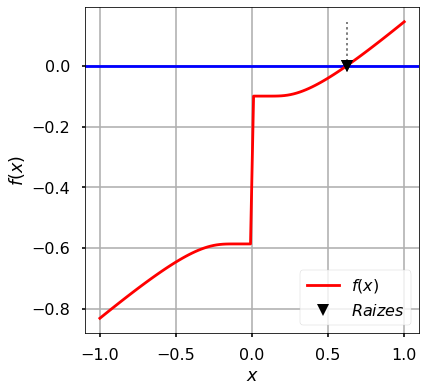

In [38]:
x = np.linspace(-1, 1, 100)
y = func(x)

raiz1 = opt.root(func, -1)
raiz2 = opt.root(func, 1)
raizes = np.array([raiz1.x, raiz2.x])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.axhline(0, color='b')

plt.vlines(x=raiz1.x, ymin=func(1), ymax=0, colors='gray', ls=':', lw=2)
plt.vlines(x=raiz2.x, ymin=func(1), ymax=0, colors='gray', ls=':', lw=2)

ax.plot(x, func(x), 'r', label="$f(x)$")
ax.plot(raizes, func(raizes), 'kv', label="$Raizes$")

ax.legend(loc='best')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

plt.grid()
plt.show()

---

### Resultado de outros métodos para fins de comparação

#### Método da Bisseção [BM]

In [39]:
comp_tb[0].append(cases(opt.root_scalar(func, bracket=[ca, cb], method='bisect').root))
opt.root_scalar(func, bracket=[ca, cb], method='bisect') 

      converged: True
           flag: 'converged'
 function_calls: 42
     iterations: 40
           root: 0.623113839808866

#### Método da Falsa Posição [R-F]

In [40]:
x, i = regula_falsi(func, ca, cb)
comp_tb[0].append(cases(x))
regula_falsi(func, ca, cb)

#### Método de Newton-Raphson [N-R]

In [41]:
comp_tb[0].append(cases(opt.root_scalar(func, fprime=cprime, x0=ca, xtol=cxtol, maxiter=cmaxit, method='newton').root))
opt.root_scalar(func, fprime=cprime, x0=cb, xtol=cxtol, maxiter=cmaxit, method='newton')

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 4
           root: 0.6231138398099891

---

### Método Proposto

In [42]:
x, i, tb = proposed_method(func, cprime, ca, cb, cxtol, cmaxit)
comp_tb[0].append(cases(x))
pd.DataFrame(tb, columns=cols)

-----------------------------------------------------------------------------------
Erro abaixo da tolerância! A raíz encontrada foi 0.6231139305095494 em 8 iterações.
-----------------------------------------------------------------------------------


,a,b,x,Erro (%)
0,-1.000000000,1.000000000,0.877409622,213.971852453
1,0.877409622,-1.000000000,0.659606256,33.020209284
2,0.659606256,-1.000000000,0.628866955,4.888045196
3,0.628866955,-1.000000000,0.624024637,0.775981795
4,0.624024637,-1.000000000,0.623258067,0.122994028
5,0.623258067,-1.000000000,0.623136679,0.019480152
6,0.623136679,-1.000000000,0.623117457,0.003084915
7,0.623117457,-1.000000000,0.623114413,0.000488523
8,0.623114413,-1.000000000,0.623113931,0.000077362


---

### Tabela de Comparação

In [43]:
pd.DataFrame(comp_tb, columns=comp_hd)

,BM,R-F,N-R,PM
0,0.623113839809,0.623113839833,0.623113839810,0.623113930510
